In [141]:

# import torch
import gc
import os
gc.collect()
import random
import itertools

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from faker import Faker
from itertools import combinations
from scipy.stats import entropy,spearmanr


In [58]:


def pagerank(A, num_iterations=10, d=0.99):
    """
    Calculate PageRank for a transition matrix A using the power iteration method.
    
    Parameters:
    - A: numpy array, the transition matrix where A[i][j] is the probability of moving from node i to node j.
    - num_iterations: int, the number of power iterations to perform.
    - d: float, the dampening factor.
    
    Returns:
    - v: numpy array, the PageRank vector.
    """
    
    # Number of nodes
    N = A.shape[0]

    # Normalize the matrix so that columns sum to 1
    epsilon = 1e-6
    col_sums = A.sum(axis=0, keepdims=True) + epsilon
    normalized_matrix = A / col_sums

    # Apply dampening
    S = np.ones((N, N)) / N
    M = d * normalized_matrix + (1 - d) * S

    # Initialize the PageRank vector
    v = np.ones(N) / N

    # Power iteration
    for _ in range(num_iterations):
        v = M @ v

    # Normalize the result
    v /= v.sum()

    return v


In [69]:
## Four team system
## A beats B
## C beats D
## Four team system
## A beats B
## C beats D
A = np.array([
    [0, 76, 91, 97],
    [24, 0, 76, 91],
    [9, 24, 0, 76],
    [3, 9, 24, 0]
])

t1 = pagerank(A, d=0.99)
t1


array([0.36785193, 0.35165667, 0.19468157, 0.08580984])

In [132]:


A = np.array([
    [0, 76-24, 91-9, 97-3],
    [0, 0, 76-24, 91-9],
    [0, 0, 0, 76-24],
    [0, 0, 0, 0]
])

t2 = pagerank(A, d=0.99)
t2


array([0.8332678 , 0.11728554, 0.03430878, 0.01513788])

In [152]:

# Function to calculate win probability based on Elo ratings
def win_probability(elo_a, elo_b):
    return 1 / (1 + 10**((elo_b - elo_a) / 400))

def simulate_games(elo_avgs= {'North': 1600, 'East': 1500, 'South': 1400}, 
                   elo_std_dev = 50, 
                   num_teams_per_division=6):
    
    # Generate Elo ratings
    elo_ratings = {}
    team_names = []
    for division, avg in elo_avgs.items():
        elo_ratings[division] = np.random.normal(avg, elo_std, num_teams_per_division)
        for i in range(num_teams_per_division):
            team_names.append(f"{division}_Team{i+1}")
            
            
            
    # Setting up the schedule
    conference_games = []
    non_conference_games = []

    # Conference games
    for division, teams_elo in elo_ratings.items():
        already_played = []
        for i in range(num_teams_per_division):
            for j in range(num_teams_per_division):
                if i != j:  # A team doesn't play against itself
                    if (j,i) not in already_played:
                        if (i,j) not in already_played:
                            already_played.append((j, i))
                            already_played.append((i, j))
                            conference_games.append((f"{division}_Team{i+1}", f"{division}_Team{j+1}"))
                            conference_games.append((f"{division}_Team{j+1}", f"{division}_Team{i+1}"))

    # Correcting the non-conference games setup
    non_conference_games = []
    # Ensure we have 5 non-conference games for each team
    non_conference_counts = {team: 0 for team in team_names}

    non_con_poss = combinations(team_names, 2)
    non_conference_games = []
    for ncp in non_con_poss:
        ## remove same division matchups
        if ncp[0][:ncp[0].find('_')] != ncp[1][:ncp[1].find('_')]:
            ## only play four non cons
            if ((ncp[0][-1] == ncp[1][-1])|\
                (str(int(ncp[0][-1])+1) == ncp[1][-1])|\
                ((ncp[0][-1]==str(num_teams_per_division)) & (ncp[1][-1]==str(1)))):
                non_conference_games.append(ncp)
        
    # Simulate game outcomes
    results = []
    for game in conference_games + non_conference_games:
        team_a, team_b = game
        division_a, division_b = team_a.split('_')[0], team_b.split('_')[0]
        elo_a, elo_b = elo_ratings[division_a][int(team_a.split('_')[1][-1])-1], elo_ratings[division_b][int(team_b.split('_')[1][-1])-1]
        prob_a_wins = win_probability(elo_a, elo_b)
        result = 'A' if np.random.rand() < prob_a_wins else 'B'
        results.append((team_a, team_b, result))


    # Construct the matrices
    mutual_matrix = np.zeros((num_teams, num_teams))
    directed_matrix = np.zeros((num_teams, num_teams))
    for game in results:
        team_a_idx = team_names.index(game[0])
        team_b_idx = team_names.index(game[1])
        if game[2] == 'A':  # Team A won
            mutual_matrix[team_a_idx][team_b_idx] += 1
            mutual_matrix[team_b_idx][team_a_idx] -= 1
            directed_matrix[team_a_idx][team_b_idx] += 1
        else:  # Team B won
            mutual_matrix[team_a_idx][team_b_idx] -= 1
            mutual_matrix[team_b_idx][team_a_idx] += 1
            directed_matrix[team_b_idx][team_a_idx] += 1
            
    return mutual_matrix, directed_matrix, elo_ratings, team_names
    
def compute_rankings(matrix):
    """
    Compute rankings of teams based on the given matrix.
    """
    scores = pagerank(matrix, d=0.99)
    ranked_teams = [x for _, x in sorted(zip(scores, team_names), reverse=True)]
    return scores, ranked_teams

def evaluate_rankings(true_ratings, ranked_teams):
    """
    Evaluate the rankings using Spearman rank correlation.
    """
    true_ranked = sorted(true_ratings, key=true_ratings.get, reverse=True)
    correlation, _ = spearmanr(true_ranked, ranked_teams)
    return correlation

# Test the process
mutual_matrix, directed_matrix, true_ratings, team_names = simulate_games()
team_pr, ranked_teams_directed = compute_rankings(directed_matrix)
# Flatten the true_ratings dictionary to have team names as keys
flattened_true_ratings = {}
for division, ratings in true_ratings.items():
    for i, rating in enumerate(ratings):
        flattened_true_ratings[f"{division}_Team{i+1}"] = rating
correlation = evaluate_rankings(flattened_true_ratings, ranked_teams_directed)
test_res = pd.DataFrame(list([(k,v) for k,v in flattened_true_ratings.items()]), columns=['team','true_rating'])
test_res['pagerank'] = team_pr


In [157]:

test_res.corr('spearman', numeric_only=True)


,true_rating,pagerank
true_rating,1.000000,0.762642
pagerank,0.762642,1.000000


In [158]:

test_res.corr(numeric_only=True)


,true_rating,pagerank
true_rating,1.000000,0.856091
pagerank,0.856091,1.000000


In [159]:
test_res

,team,true_rating,pagerank
0,North_Team1,1721.002689,0.107911
1,North_Team2,1531.338492,0.070356
2,North_Team3,1618.178396,0.090546
3,North_Team4,1553.092306,0.075476
4,North_Team5,1562.074367,0.083488
5,North_Team6,1668.897759,0.122131
6,East_Team1,1403.623879,0.044801
7,East_Team2,1454.517720,0.029629
8,East_Team3,1457.656059,0.021405
9,East_Team4,1557.627889,0.044624


In [85]:


# Number of teams and divisions
num_teams_per_division = 6
num_divisions = 3

# Elo settings
elo_avgs = {'North': 1600, 'East': 1500, 'South': 1400}
elo_std = 50

# Generate Elo ratings
elo_ratings = {}
team_names = []
for division, avg in elo_avgs.items():
    elo_ratings[division] = np.random.normal(avg, elo_std, num_teams_per_division)
    for i in range(num_teams_per_division):
        team_names.append(f"{division}_Team{i+1}")

elo_ratings, team_names




({'North': array([1636.87851246, 1570.18016067, 1575.50974332, 1603.72273168,
         1630.46131608, 1640.74881825]),
  'East': array([1547.2191816 , 1467.09309237, 1522.01735531, 1590.11357419,
         1538.68090615, 1412.73559594]),
  'South': array([1414.32809342, 1454.54759725, 1389.04688903, 1392.09527074,
         1454.06825167, 1373.73934664])},
 ['North_Team1',
  'North_Team2',
  'North_Team3',
  'North_Team4',
  'North_Team5',
  'North_Team6',
  'East_Team1',
  'East_Team2',
  'East_Team3',
  'East_Team4',
  'East_Team5',
  'East_Team6',
  'South_Team1',
  'South_Team2',
  'South_Team3',
  'South_Team4',
  'South_Team5',
  'South_Team6'])

In [126]:
print((14*18)/2, len(results))


126.0 126


In [129]:
num_teams = 18

# Construct the matrices again
mutual_matrix = np.zeros((num_teams, num_teams))
directed_matrix = np.zeros((num_teams, num_teams))

for game in results:
    team_a_idx = team_names.index(game[0])
    team_b_idx = team_names.index(game[1])
    
    if game[2] == 'A':  # Team A won
        mutual_matrix[team_a_idx][team_b_idx] += 1
        mutual_matrix[team_b_idx][team_a_idx] -= 1
        directed_matrix[team_a_idx][team_b_idx] += 1
    else:  # Team B won
        mutual_matrix[team_a_idx][team_b_idx] -= 1
        mutual_matrix[team_b_idx][team_a_idx] += 1
        directed_matrix[team_b_idx][team_a_idx] += 1


In [130]:

pagerank(mutual_matrix)


array([ 6.17328614e+04, -4.09519516e+11,  1.87003619e+12, -8.19035521e+11,
       -6.41483644e+11,  8.19035038e+11,  8.19036953e+11, -1.37027193e+06,
        4.47032993e+12, -2.52870131e+12, -9.79408751e+11,  2.60029461e+12,
       -2.60029368e+12, -3.24177521e+12, -2.60029182e+12,  3.20745275e+11,
        4.22118215e+12, -1.30014939e+12])

In [131]:
pagerank(directed_matrix)

array([0.05095547, 0.05227351, 0.07155906, 0.06809909, 0.07683491,
       0.08490955, 0.05080398, 0.06990573, 0.0514212 , 0.08186263,
       0.05325508, 0.07131009, 0.02655616, 0.04032125, 0.03729009,
       0.03426004, 0.03064464, 0.04773752])

In [10]:

## Four team system
## A beats B
## C beats D
A = np.array([
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])

v = np.array([1, 1, 1, 1]).reshape(-1,1)

for i in range(10):
    v = A@v
    norm = np.linalg.norm(v, axis=0)
    v = v/norm
    print(i, v)


0 [[0.57735027]
 [0.57735027]
 [0.57735027]
 [0.        ]]
1 [[0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]]
2 [[1.]
 [0.]
 [0.]
 [0.]]
3 [[nan]
 [nan]
 [nan]
 [nan]]
4 [[nan]
 [nan]
 [nan]
 [nan]]
5 [[nan]
 [nan]
 [nan]
 [nan]]
6 [[nan]
 [nan]
 [nan]
 [nan]]
7 [[nan]
 [nan]
 [nan]
 [nan]]
8 [[nan]
 [nan]
 [nan]
 [nan]]
9 [[nan]
 [nan]
 [nan]
 [nan]]


C:\Users\Blake\AppData\Local\Temp\ipykernel_6552\2059090309.py:16: RuntimeWarning: invalid value encountered in divide
  v = v/norm


In [ ]:

##


In [161]:

A1 = np.array([
    [0,1,2,3,1],
    [0,0,1,2,1],
    [0,0,0,1,1],
    [0,0,0,0,1],
    [0,0,0,0,0]
])

entropy(A1)




array([0.        , 0.69314718, 1.03972077, 1.27703426, 0.        ])

In [146]:

A2 = np.array([
    [1,1,2,3],
    [0,1,1,2],
    [0,0,1,1],
    [0,0,0,1]
])

entropy(A1)


array([      -inf,       -inf, 1.01140426, 1.27985423])

In [28]:

### 8 team system
ratings = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'E':-1,
    'F':-2,
    'G':-3,
    'H':-4
}
def play_game(skill_1, skill_2, variation = 4):
    return np.random.normal(skill_1-skill_2, variation)
name2idx = {team_name:i for i, team_name in enumerate(ratings.keys())}
n_players = 8
schedule = list(combinations(['A','B','C','D','E','F','G','H'], 2))
rating_matrix = np.zeros((n_players, n_players))
schedule = pd.DataFrame(schedule, columns=['team_1','team_2'])
schedule['game_result'] = schedule.apply(lambda x: play_game(ratings[x.team_1], ratings[x.team_2]), axis=1)
for index, row in schedule.iterrows():
    if row['game_result']>0:
        rating_matrix[name2idx[row['team_1']], name2idx[row['team_2']]] = row['game_result']
    else:
        rating_matrix[name2idx[row['team_2']], name2idx[row['team_1']]] = np.abs(row['game_result'])

def calc_multiple_ratings(A, D, num_iterations=100):

#         dampen = 1/(num_players**2)
#         A = (dampen * A + (1 - dampen) / num_players) 

        for i in range(num_iterations):
            v = np.matmul(A, v)
            norm = np.linalg.norm(v, axis=0)
            v = v/norm
        return v*num_players
    
ratings_vector = np.random.random(8)



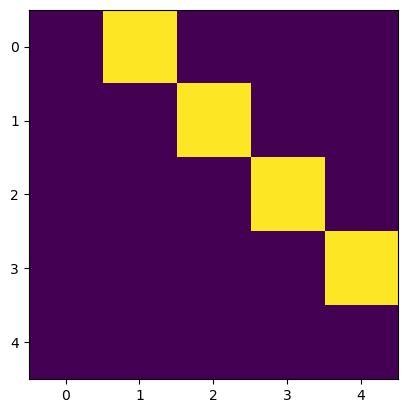

In [121]:

%matplotlib inline 
from matplotlib import pyplot as plt
plt.imshow(A, interpolation='nearest')
plt.show()


In [124]:
np.matmul(A, v)

array([[0.85018224],
       [0.84291062],
       [0.8000487 ],
       [0.68251425],
       [0.35448491]])

In [33]:

one_way_rtg = calc_multiple_ratings(rating_matrix, ratings_vector, 8)


In [ ]:

one_way_rtg = 


In [31]:

 avg_rtg = (calc_multiple_ratings(rating_matrix, ratings_vector, 8) + -1*calc_multiple_ratings(rating_matrix.T, ratings_vector, 8))/2



array([0.89321062, 0.98868803, 0.65785616, 2.16030061, 2.44533437,
       3.23212466, 3.5770015 , 5.28240168])

In [37]:
A = np.array([
    [0,5,0,0,0],
    [0,0,5,0,0],
    [0,0,0,5,0],
    [0,0,0,0,5],
    [0,0,0,0,0]
])
v = np.ones(5).reshape(-1,1)
v_1 = np.matmul(A, v)
print(v_1)
v_2 = np.matmul(A, v_1)
print(v_2)


[[5.]
 [5.]
 [5.]
 [5.]
 [0.]]
[[25.]
 [25.]
 [25.]
 [ 0.]
 [ 0.]]


In [141]:
D = np.array([
    [0,1,0,0,0,1],
    [1,0,1,0,0,1],
    [0,1,0,1,0,1],
    [0,0,1,0,1,1],
    [0,0,0,1,0,1],
    [1,1,1,1,1,1]
])
## Experiment with different relative skills
A = np.array([
    [0,5,0,0,0,1],
    [0,0,4,0,0,1],
    [0,0,0,3,0,1],
    [0,0,0,0,2,1],
    [0,0,0,0,0,1],
    [0,0,0,0,0,0],
])
num_players=6
dampen = 1/(num_players**2)
A = (dampen * A + (1 - dampen) / num_players) 
D = (dampen * D + (1 - dampen) / num_players) 
# print(D-A)
v = np.ones(6).reshape(-1,1)
for i in range(25):
    v = np.matmul(A/D, v)
    norm = np.linalg.norm(v, axis=0)
    v = v/norm
    v2 = np.ones(6).reshape(-1,1)
for i in range(25):
    v2 = np.matmul((A.T/D), v2)
    norm = np.linalg.norm(v2, axis=0)
    v2 = v2/norm
(v + -1*v2)/2



array([[ 0.03034551],
       [ 0.00031434],
       [-0.0015252 ],
       [-0.0011311 ],
       [-0.00558418],
       [-0.0254219 ]])

In [139]:
## Experiment with different relative skills
A = np.array([
    [0,5,0,0,0,1],
    [0,0,4,0,0,1],
    [0,0,0,3,0,1],
    [0,0,0,0,2,1],
    [0,0,0,0,0,1],
    [0,0,0,0,0,0],
])

num_players=6
dampen = 1/(num_players)
A = (dampen * A + (1 - dampen) / num_players) 

v = np.ones(6).reshape(-1,1)
for i in range(30):
    v = np.matmul(A, v)
    norm = np.linalg.norm(v, axis=0)
    v = v/norm
v2 = np.ones(6).reshape(-1,1)

for i in range(30):
    v2 = np.matmul((A.T), v2)
    norm = np.linalg.norm(v2, axis=0)
    v2 = v2/norm

## key insight: for small systems like this, it's good to average between A
## and -1*A.T
(v + -1*v2)/2


array([[ 0.16507776],
       [ 0.03613809],
       [-0.02547549],
       [-0.03941757],
       [-0.04118805],
       [-0.1233999 ]])

In [147]:

## Experiment with different relative skills
A = np.array([
    [0,5,0,0,0],
    [0,0,4,0,0],
    [0,0,0,3,0],
    [0,0,0,0,2],
    [0,0,0,0,0],
])

num_players=5
dampen = 1/(num_players)
A = (dampen * A + (1 - dampen) / num_players) 

v = np.ones(5).reshape(-1,1)
for i in range(30):
    v = np.matmul(A, v)
    norm = np.linalg.norm(v, axis=0)
    v = v/norm
v2 = np.ones(5).reshape(-1,1)

for i in range(30):
    v2 = np.matmul((A.T), v2)
    norm = np.linalg.norm(v2, axis=0)
    v2 = v2/norm

## key insight: for small systems like this, it's good to average between A
## and -1*A.T
(v + -1*v2)/2



array([[ 0.18613352],
       [ 0.02116258],
       [-0.06575858],
       [-0.08582143],
       [-0.07889244]])

In [156]:


## Experiment with different relative skills
A = np.array([
    [0,5,0,0,0,1],
    [0,0,4,0,0,1],
    [0,0,0,3,0,1],
    [0,0,0,0,2,1],
    [0,0,0,0,0,1],
    [0,0,0,0,0,0]
])

num_players=6
dampen = 1/(num_players)
A = (dampen * A + (1 - dampen) / num_players) 

v = np.ones(6).reshape(-1,1)
for i in range(30):
    v = np.matmul(A, v)
    norm = np.linalg.norm(v, axis=0)
    v = v/norm
v2 = np.ones(6).reshape(-1,1)

for i in range(30):
    v2 = np.matmul((A.T), v2)
    norm = np.linalg.norm(v2, axis=0)
    v2 = v2/norm

## key insight: for small systems like this, it's good to average between A
## and -1*A.T
(v + -1*v2)/2


array([[ 0.16507776],
       [ 0.03613809],
       [-0.02547549],
       [-0.03941757],
       [-0.04118805],
       [-0.1233999 ]])

In [120]:
A/D

array([[1.        , 2.07142857, 1.        , 1.        , 1.        ],
       [0.28571429, 1.        , 3.22222222, 1.        , 1.        ],
       [1.        , 0.44444444, 1.        , 3.22222222, 1.        ],
       [1.        , 1.        , 0.44444444, 1.        , 3.22222222],
       [1.        , 1.        , 1.        , 0.44444444, 1.        ]])

In [69]:
L = A/D
v = np.ones(5).reshape(-1,1)
v = np.matmul(A/D, v)
v

array([[7.59803922],
       [8.08823529],
       [8.18965517],
       [8.18965517],
       [4.02298851]])

In [8]:



# def calc_multiple_ratings(rtg_matrix, player_rtgs, num_players, num_iterations=100):

#         dampen = 1/(num_players**2)
#         A = (dampen * rtg_matrix + (1 - dampen) / num_players) 
#         v = torch.clone(player_rtgs)

#         for i in range(num_iterations):
#             v = torch.einsum('ijk,jk->ik', A, v)
#             norm = torch.linalg.norm(v, axis=0)
#             v = v/norm
#         return v*num_players


array([[ 0.        ,  0.        ,  0.05760158,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 2.62489519,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.85995336,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 3.76332862,  3.86000261,  6.05640029,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 7.56259201,  8.52798376,  5.22562779,  8.35293767,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 3.4032825 , 10.18248646,  4.3882451 ,  2.0850992 ,  0.3411896 ,
         0.        ,  3.7425629 ,  0.        ],
       [ 7.61736012, 10.47983922, 12.26508833,  4.86301124,  6.45095098,
         0.        ,  0.        ,  0.        ],
       [ 4.3874254 ,  0.74097548,  7.78092284,  5.5404988 ,  1.14060716,
         8.75901256,  5.35766935,  0.        ]])